# **Predicting Used Car Price**<a id='home'></a>

**Background:** Rusty Bargain used cars is developing an app where customers can quickly find the market value of their car. The app needs to be both accurate and efficient. 

**Purpose:** Train a regression model that accurately and quickly predicts the market value of a new customer's car minimizing RMSE.

**Techniques:** One Hot Encoding, Pipelines, GridSearchCV, Gradient Boosting with CatBoost and LightGBM.

**Sections:**
* [Import Packages and Data](#import)
* [Prepare Data](#prepare)
* [Exploratory Anaylsis](#explore)
* [Regression Model Training (Gradient Boosting)](#model)
* [Conclusion and Business Application](#conclusion)

## **Import Packages and Data** <a id='import'></a>

### Standard packages

In [345]:
# General
import math
import numpy as np
import pandas as pd
import re
import time

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Gradient boosting
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

### User-defined functions

In [346]:
# Frequency table function
def freq_table(df, column):
    '''Takes a pd.DataFrame and column name and returns a
    pd.DataFrame with values, count, percent, and cumulative 
    percent.
    
    df: pandas.DataFrame object
    column: column name'''
    table = df[column].value_counts().reset_index()
    table['percent'] = (table['count'] / len(df)) * 100
    table['cumulative_percent'] = np.cumsum(table['percent'])
    
    pd.set_option('display.min_rows', 30, 'display.max_rows', 50)
    
    return table

In [347]:
# Cross_validate results function
def cv_results(cv_object, main_scorer, *add_scores, greater_is_better=True):
    '''Take a sklearn cross_validate object and return a pandas dataframe 
    of averaged scores for the best model.
    
    cv_object: fitted cross_validate object with one or multiple scorers.
    main_scorer: scorer passed to cross_validate object, or refit score if cross_validate
                 has multiple scorers.
    add_scores: list of additional score names passed to cv_object.'''
     # create data frame with best main score
    if greater_is_better:
        main_scorer_avg = cv_object[f'test_{main_scorer}'].mean().round(4)
    else:
        main_scorer_avg = -1 * (cv_object[f'test_{main_scorer}'].mean().round(4))
    
    results = pd.DataFrame(data={f'{main_scorer}': [main_scorer_avg]})
    
    # for score in additional scores, calculate average and add column with score
    for score in add_scores:
        score_avg = cv_object[f'test_{score}'].mean()
        results[f'{score}'] = score_avg
    
    return results

In [348]:
# GridSearchCV results function
def gscv_results(gscv_object, main_scorer, *add_scores, greater_is_better=True):
    '''Take an sklearn GridSearchCV object and return a tuple of best model 
    parameters and pandas dataframe of scores for the best model.
    
    gscv_object: fitted GridSearchCV object with one or multiple scorers.
    main_scorer: scorer passed to gscv_object, or refit score if gscv_object is passed multiple scorers.
    add_scores: list of additional score names passed to gscv_object.'''
    cv_results = pd.DataFrame(gscv_object.cv_results_).sort_values(by=f'mean_test_{main_scorer}', ascending=False)

    best_params = gscv_object.best_params_
    best_index = gscv_object.best_index_

    # create data frame with best main score
    if greater_is_better:
        best_score = gscv_object.best_score_.round(4)
    else:
        best_score = -1 * (gscv_object.best_score_.round(4))
    
    results = pd.DataFrame(data={f'{main_scorer}':[best_score]})
    
    # for score in additional scores, add column with best model score 
    for score in add_scores:
        results[f'{score}'] = cv_results.loc[best_index, f'mean_test_{score}'].round(4)

    return best_params, results

### Read data

In [349]:
# Read in data
cars = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/car_data.csv')

In [350]:
# Print info
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

There are missing values. Some data types are incorrect.

In [351]:
# Print sample of rows
display(cars.sample(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
147739,24/03/2016 12:47,549,sedan,1994,auto,211,omega,150000,12,petrol,opel,no,24/03/2016 00:00,0,24623,24/03/2016 12:47
288485,20/03/2016 13:46,2990,bus,2009,manual,94,zafira,150000,2,cng,opel,NaN,20/03/2016 00:00,0,12527,20/03/2016 13:46
129019,18/03/2016 10:47,3999,bus,2008,NaN,0,meriva,150000,12,petrol,opel,no,18/03/2016 00:00,0,22547,21/03/2016 07:15
227461,17/03/2016 16:46,1999,NaN,2017,manual,166,6_reihe,150000,6,NaN,mazda,no,17/03/2016 00:00,0,1187,20/03/2016 18:36
205026,09/03/2016 19:58,900,NaN,2000,NaN,0,kangoo,150000,9,NaN,renault,NaN,09/03/2016 00:00,0,32339,12/03/2016 06:17
9185,28/03/2016 17:51,8499,suv,2001,auto,193,other,150000,7,lpg,chevrolet,no,28/03/2016 00:00,0,71665,06/04/2016 23:45
29454,14/03/2016 16:59,400,sedan,1995,manual,75,golf,150000,5,petrol,volkswagen,yes,14/03/2016 00:00,0,27804,19/03/2016 04:44
341509,07/03/2016 18:41,4150,small,2011,manual,75,twingo,60000,8,petrol,renault,no,07/03/2016 00:00,0,40476,19/03/2016 16:18
174555,03/04/2016 13:49,2000,sedan,1997,manual,150,a4,150000,0,petrol,audi,no,03/04/2016 00:00,0,91580,05/04/2016 12:46
337944,19/03/2016 14:42,7800,coupe,1999,manual,224,tt,150000,11,petrol,audi,no,19/03/2016 00:00,0,74348,06/04/2016 21:18


### Initial data observations

There are 354,369 rows and 16 columns in the dataset. Some columns have missing values. All three date columns need to be changed to date time. Column names need to be converted to snake case.

[back to top](#home)

## **Prepare Data** <a id='prepare'></a>

Convert columns to snake case, fix data types, address missing values and duplicates, and examine categorical and numeric columns for incorrect entries.

### Convert column names to snake case

In [352]:
# Convert columns from camel case to snake case
new_columns = []
for column in cars.columns:
    # regex to find capital letter that is not the first letter
    # and add underscore behind it
    column = re.sub('(?<!^)(?=[A-Z])', '_', column).lower()
    new_columns.append(column)

# Replace columns names with new names
cars.columns = new_columns

print('Column names (snake case):')
print()
print(cars.columns)

Column names (snake case):

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')


Column names are converted to snake case.

### Fix data types

Convert date columns to datetime.

In [353]:
# Date columns
cols_date = ['date_crawled', 'date_created', 'last_seen']

for col in cols_date:
    # convert to datetime using day first format
    cars[col] = pd.to_datetime(cars[col], dayfirst=True)

print('Data types:')
print(cars.dtypes)
print()
print('Data frame:')
display(cars.sample(5))

Data types:
date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
mileage                        int64
registration_month             int64
fuel_type                     object
brand                         object
not_repaired                  object
date_created          datetime64[ns]
number_of_pictures             int64
postal_code                    int64
last_seen             datetime64[ns]
dtype: object

Data frame:


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
154236,2016-03-14 12:46:00,3650,convertible,2002,manual,0,mx_reihe,125000,1,petrol,mazda,NaN,2016-03-14,0,27607,2016-04-05 12:45:00
310163,2016-03-23 17:39:00,4100,small,2009,manual,60,polo,100000,2,petrol,volkswagen,no,2016-03-23,0,37181,2016-03-23 17:39:00
305955,2016-03-13 00:59:00,1333,sedan,1998,manual,165,a6,150000,12,petrol,audi,yes,2016-03-12,0,57462,2016-03-14 21:46:00
135937,2016-04-01 19:55:00,6500,NaN,2017,manual,140,passat,150000,11,gasoline,volkswagen,no,2016-04-01,0,53879,2016-04-01 19:55:00
348599,2016-04-07 09:06:00,150,bus,1997,manual,90,scenic,150000,11,petrol,renault,no,2016-04-07,0,35390,2016-04-07 09:25:00


Date columns are converted to date time.

### Address missing values

In [399]:
# Print number and percent of missing values for each column
missing = cars.isna().sum().to_frame().rename(
    columns={0:'number'})
missing['proportion'] = (missing['number'] / len(cars)).round(2)

print('Missing values by column:')
display(missing)

Missing values by column:


,number,proportion
date_crawled,0,0.0
price,0,0.0
vehicle_type,0,0.0
registration_year,0,0.0
gearbox,0,0.0
power,0,0.0
model,0,0.0
mileage,0,0.0
registration_month,0,0.0
fuel_type,0,0.0


There are missing values in vehicle_type, gearbox, model, fuel_type, and not_repaired. All missing data are strings. String missing values will be replaced with 'unknown'.

In [400]:
# Replace missing strings with 'unknown'
cols_string = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']

cars[cols_string] = cars[cols_string].fillna('unknown')

# Re-calculate missing values
missing_new = cars.isna().sum().to_frame().rename(
    columns={0:'number'})
missing_new['proportion'] = (missing_new['number'] / len(cars)).round(2)

print('Missing values after filling strings:')
display(missing_new)

Missing values after filling strings:


,number,proportion
date_crawled,0,0.0
price,0,0.0
vehicle_type,0,0.0
registration_year,0,0.0
gearbox,0,0.0
power,0,0.0
model,0,0.0
mileage,0,0.0
registration_month,0,0.0
fuel_type,0,0.0


All missing strings have been filled with 'unknown'

### Check for duplicates

In [356]:
# Check for full duplicates
duplicates_num = cars.duplicated().sum()

print(f'Full duplicates: {duplicates_num}')

Full duplicates: 262


In [357]:
# View duplicates
duplicates = cars.duplicated(keep=False)

display(cars[duplicates].sort_values(by='date_crawled'))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
136532,2016-03-05 14:11:00,3700,coupe,2006,manual,101,astra,150000,7,gasoline,opel,no,2016-03-03,0,55218,2016-03-06 03:44:00
238082,2016-03-05 14:11:00,3700,coupe,2006,manual,101,astra,150000,7,gasoline,opel,no,2016-03-03,0,55218,2016-03-06 03:44:00
51617,2016-03-05 14:12:00,2689,small,2005,auto,61,fortwo,90000,7,petrol,smart,no,2016-03-03,0,56412,2016-04-05 04:49:00
53329,2016-03-05 14:12:00,2689,small,2005,auto,61,fortwo,90000,7,petrol,smart,no,2016-03-03,0,56412,2016-04-05 04:49:00
234836,2016-03-05 14:13:00,17000,wagon,2009,manual,170,a4,150000,9,gasoline,audi,no,2016-03-03,0,35792,2016-04-07 03:45:00
88029,2016-03-05 14:13:00,800,wagon,1997,manual,90,golf,150000,1,gasoline,volkswagen,no,2016-03-03,0,57539,2016-03-07 18:46:00
231424,2016-03-05 14:13:00,17000,wagon,2009,manual,170,a4,150000,9,gasoline,audi,no,2016-03-03,0,35792,2016-04-07 03:45:00
303629,2016-03-05 14:13:00,800,wagon,1997,manual,90,golf,150000,1,gasoline,volkswagen,no,2016-03-03,0,57539,2016-03-07 18:46:00
95014,2016-03-05 14:16:00,850,small,2002,manual,53,swift,150000,1,petrol,suzuki,no,2016-03-04,0,35794,2016-03-15 01:17:00
75792,2016-03-05 14:16:00,850,small,2002,manual,53,swift,150000,1,petrol,suzuki,no,2016-03-04,0,35794,2016-03-15 01:17:00


There do appear to be duplicate entries in the dataset, with the same cars entered twice, down to the minute of the date the profile was downloaded and the time of the last activity of the user. These duplicates will be deleted from the dataset.

In [401]:
# Delete duplicate entries
cars = cars.drop_duplicates()

duplicates_new = cars.duplicated().sum()

print(f'Duplicates after deletion: {duplicates_new}')

Duplicates after deletion: 0


Duplicates have been deleted from the dataframe.

### Examine categorical values

##### Frequency tables

Produce frequency table for each categorical feature.

In [359]:
# Frequency tables of string variables

# Apply frequency table function to each string variable
freq_vehicle = freq_table(cars, 'vehicle_type')
freq_gear = freq_table(cars, 'gearbox')
freq_model = freq_table(cars, 'model')
freq_fuel = freq_table(cars, 'fuel_type')
freq_brand = freq_table(cars, 'brand')
freq_repair = freq_table(cars, 'not_repaired')
freq_postal = freq_table(cars, 'postal_code')

# Display tables
print('Frequency Table vehicle type:')
display(freq_vehicle.round(2))
print('Frequency Table gearbox:')
display(freq_gear.round(2))
print('Frequency Table model:')
display(freq_model.round(2))
print('Frequency Table fuel:')
display(freq_fuel.round(2))
print('Frequency Table vehicle brand:')
display(freq_brand.round(2))
print('Frequency Table repair:')
display(freq_repair.round(2))
print('Frequency Table postal code:')
display(freq_postal.round(2))

Frequency Table vehicle type:


,vehicle_type,count,percent,cumulative_percent
0,sedan,91399,25.81,25.81
1,small,79753,22.52,48.33
2,wagon,65115,18.39,66.72
3,unknown,37484,10.59,77.31
4,bus,28752,8.12,85.43
5,convertible,20180,5.70,91.13
6,coupe,16147,4.56,95.69
7,suv,11991,3.39,99.07
8,other,3286,0.93,100.00


Frequency Table gearbox:


,gearbox,count,percent,cumulative_percent
0,manual,268034,75.69,75.69
1,auto,66243,18.71,94.40
2,unknown,19830,5.60,100.00


Frequency Table model:


,model,count,percent,cumulative_percent
0,golf,29215,8.25,8.25
1,other,24402,6.89,15.14
2,3er,19744,5.58,20.72
3,unknown,19701,5.56,26.28
4,polo,13057,3.69,29.97
5,corsa,12559,3.55,33.51
6,astra,10800,3.05,36.56
7,passat,10137,2.86,39.43
8,a4,9894,2.79,42.22
9,c_klasse,8307,2.35,44.57


Frequency Table fuel:


,fuel_type,count,percent,cumulative_percent
0,petrol,216161,61.04,61.04
1,gasoline,98658,27.86,88.91
2,unknown,32889,9.29,98.19
3,lpg,5307,1.50,99.69
4,cng,565,0.16,99.85
5,hybrid,233,0.07,99.92
6,other,204,0.06,99.97
7,electric,90,0.03,100.00


Frequency Table vehicle brand:


,brand,count,percent,cumulative_percent
0,volkswagen,76960,21.73,21.73
1,opel,39902,11.27,33.00
2,bmw,36881,10.42,43.42
3,mercedes_benz,32025,9.04,52.46
4,audi,29439,8.31,60.77
5,ford,25163,7.11,67.88
6,renault,17915,5.06,72.94
7,peugeot,10988,3.10,76.04
8,fiat,9634,2.72,78.76
9,seat,6901,1.95,80.71


Frequency Table repair:


,not_repaired,count,percent,cumulative_percent
0,no,246927,69.73,69.73
1,unknown,71145,20.09,89.82
2,yes,36035,10.18,100.00


Frequency Table postal code:


,postal_code,count,percent,cumulative_percent
0,10115,819,0.23,0.23
1,65428,611,0.17,0.40
2,66333,343,0.10,0.50
3,44145,316,0.09,0.59
4,32257,316,0.09,0.68
5,52525,306,0.09,0.77
6,26789,296,0.08,0.85
7,78224,292,0.08,0.93
8,38518,291,0.08,1.01
9,13357,290,0.08,1.10


* Vehicle_type, gearbox, fuel_type, and not_reparied all have under 10 categories. They can be modeled as is. 
* Model, brand, and postal_code all have over 20 categories. Their categories will need to be reduced before modeling.

### Reduce categorical values

##### Postal code

States are determined by the first 2 numbers in a postal code. Postal codes will be truncated to first 2 numbers to reduce categories while keeping region information.

In [360]:
# Function to truncate to 1000
def trunc_1000(x):
    return math.trunc(x / 1000) * 1000

# Create new feature with truncated postal code
cars['postal_code_trunc1000'] = cars['postal_code'].apply(trunc_1000)

display(cars.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,postal_code_trunc1000
0,2016-03-24 11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:00,70000
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:00,66000
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:00,90000
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00,91000
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00,60000


In [361]:
# Re-calculate postal_code freq table
freq_postal_trunc1000 = freq_table(cars, 'postal_code_trunc1000')

print('Reduced postal code frequency table:')
display(freq_postal_trunc1000)

Reduced postal code frequency table:


,postal_code_trunc1000,count,percent,cumulative_percent
0,45000,8366,2.362563,2.362563
1,26000,7725,2.181544,4.544107
2,66000,7188,2.029895,6.574002
3,65000,7024,1.983581,8.557583
4,44000,6508,1.837863,10.395445
5,49000,6375,1.800303,12.195749
6,56000,6037,1.704852,13.900601
7,47000,6002,1.694968,15.595569
8,35000,5906,1.667857,17.263426
9,24000,5718,1.614766,18.878192


Postal code has been reduced to 94 categories.

##### Plot cumulative frequency curves

Cumulative frequency curves are produced to determine if categories can be further reduced.

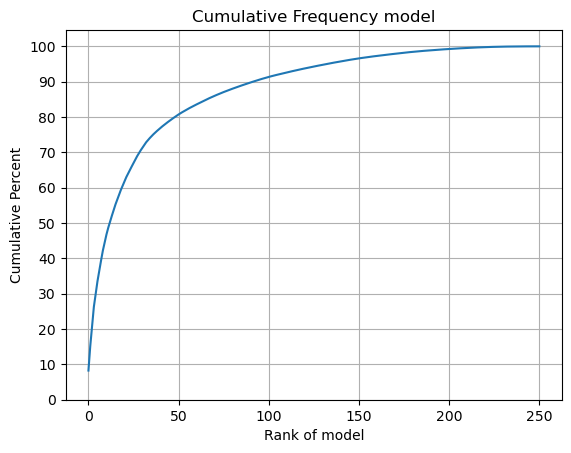

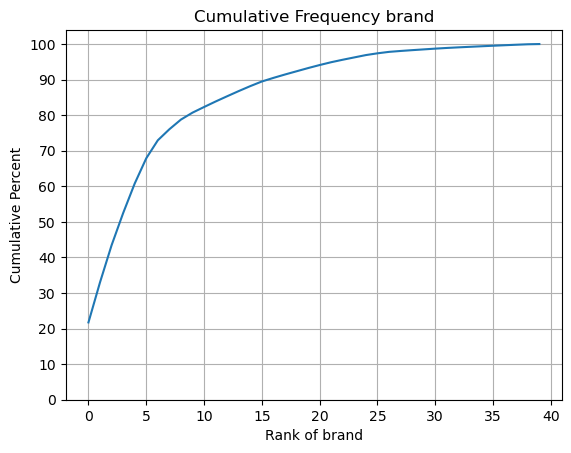

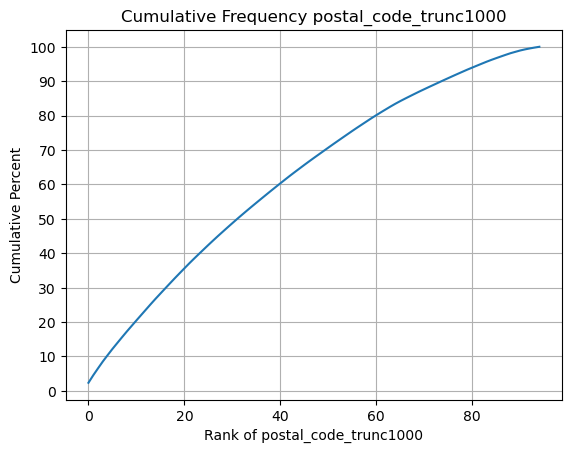

In [362]:
# plot cdf of model, brand, and postal_code
freq_tables = [freq_model, freq_brand, freq_postal_trunc1000]

for table in freq_tables:
    plt.plot(table['cumulative_percent'])
    
    plt.title(f'Cumulative Frequency {table.columns[0]}')
    plt.ylabel('Cumulative Percent')
    plt.xlabel(f'Rank of {table.columns[0]}')
    plt.yticks(np.arange(0, 101, 10))
    plt.grid(visible=True)
    
    plt.show()

*<b>Model:</b>* About 80% of models are explained by the first 50 models. About 95% of models are explained by the first 125 models.  

*<b>Brand:</b>* About 85% of brands are explained by the first 10 brands. About 95% of brands are explained by the first 20 brands.  

*<b>Postal code (truncated 1000):</b>* About 85% of all postal codes are explained by the first 70 postal codes. About 95% of all postal codes are explained by the first 80 postal codes.

Model could be reduced to the first 50 or 125 categories. Brand can be reduced to the first 10 - 20 brands. Postal code was better reduced by truncating to the 1000s place and doesn't have a clear further further reduction.

##### Reduce model and brand categories

*Model*

Reduce model to top 125 categories.

In [363]:
# List of top 125 models
top_125 = freq_model.loc[0:124, 'model'].to_list()

# Reduce categories function
def model_reduction(x):
    if x in top_125:
        return x
    else:
        return 'other'

# Apply function to make new top 125 feature
cars['model_top125'] = cars['model'].apply(model_reduction)

# Re-print frequency table
freq_model_top125 = freq_table(cars, 'model_top125')

print('Model top 125 frequency table:')
display(freq_model_top125)

Model top 125 frequency table:


,model_top125,count,percent,cumulative_percent
0,other,45006,12.709718,12.709718
1,golf,29215,8.250331,20.960049
2,3er,19744,5.575716,26.535765
3,unknown,19701,5.563573,32.099337
4,polo,13057,3.687304,35.786641
5,corsa,12559,3.546668,39.333309
6,astra,10800,3.049926,42.383234
7,passat,10137,2.862694,45.245928
8,a4,9894,2.794071,48.039999
9,c_klasse,8307,2.345901,50.385900


Model is reduced to 125 categories.

*Brand*

Reduce brand to top 20 categories.

In [364]:
# List of top 20 brands
brand_top20 = freq_brand.loc[0:18, 'brand'].to_list()

# Function to determine if value in top brands
def top_brand(x):
    if x in brand_top20:
        return x
    else:
        return 'other'
    
# Apply function to make new feature
cars['brand_top20'] = cars['brand'].apply(top_brand)

# Frequency table of brand_top20
freq_top20 = freq_table(cars, 'brand_top20')

print('Brand top 20 frequency table:')
display(freq_top20)

Brand top 20 frequency table:


,brand_top20,count,percent,cumulative_percent
0,volkswagen,76960,21.733544,21.733544
1,opel,39902,11.268345,33.001889
2,bmw,36881,10.415213,43.417103
3,mercedes_benz,32025,9.043877,52.460979
4,audi,29439,8.313589,60.774568
5,other,27114,7.657008,68.431576
6,ford,25163,7.106044,75.537620
7,renault,17915,5.059205,80.596825
8,peugeot,10988,3.103017,83.699842
9,fiat,9634,2.720647,86.420489


Brand is reduced to the top 20 categories.

### Examine Numeric features

*Descriptive statistics*

Check numeric variable values.

In [365]:
# Descriptive statistics of quantitative variables
cols_numeric = ['price', 'registration_year', 'power', 'mileage', 'registration_month', 'number_of_pictures']

cars[cols_numeric].describe().round(2)

,price,registration_year,power,mileage,registration_month,number_of_pictures
count,354107.00,354107.00,354107.00,354107.00,354107.00,354107.0
mean,4416.43,2004.24,110.09,128211.81,5.71,0.0
std,4514.34,90.26,189.91,37906.59,3.73,0.0
min,0.00,1000.00,0.00,5000.00,0.00,0.0
25%,1050.00,1999.00,69.00,125000.00,3.00,0.0
50%,2700.00,2003.00,105.00,150000.00,6.00,0.0
75%,6400.00,2008.00,143.00,150000.00,9.00,0.0
max,20000.00,9999.00,20000.00,150000.00,12.00,0.0


Minimum and maximum values for registration_year, power, and number_of_pictures are outside the range of possible values. 

*<b>Registration_year:</b>* Ranges from 1000 to 9999 and should not be less than 1900 or more than 2023.  
*<b>Power:</b>* Ranges fro 0 to 20000 and should not be less than 1 or more than 2000.   

Values outside those ranges were likely mis-entered and will be cleaned from the dataset. 

*<b>Pictures:</b>* All cars have 0 pictures. This was likely not recorded on the website or not downloaded correctly from the site. This variable will removed from the analysis.

*Registration_year*

Examine registration year distribution and delete incorrect values.

In [366]:
# Print values of registriation year
freq_reg = freq_table(cars, 'registration_year')

print('Frequency table of registration_year:')
display(freq_reg[['registration_year', 'count', 'percent']].sort_values(by='registration_year')
        .reset_index(drop=True))

Frequency table of registration_year:


,registration_year,count,percent
0,1000,37,0.010449
1,1001,1,0.000282
2,1039,1,0.000282
3,1111,3,0.000847
4,1200,1,0.000282
5,1234,4,0.001130
6,1253,1,0.000282
7,1255,1,0.000282
8,1300,2,0.000565
9,1400,1,0.000282


There are multiple mis-entered values below 1900 and above 2023. These values likely all represent mis-entered or unknown and will be replaced with nan.

In [367]:
# Replace registrations years < 1900 and > 2023 with nan
def reg_year_bound(x):
    if x < 1900:
        return np.nan
    elif x > 2023:
        return np.nan
    else:
        return x

# apply year function
cars['registration_year'] = cars['registration_year'].apply(reg_year_bound)

print('Updated registration_year descriptives')
display(cars['registration_year'].describe().round(2))

Updated registration_year descriptives


count    353936.00
mean       2003.08
std           7.54
min        1910.00
25%        1999.00
50%        2003.00
75%        2008.00
max        2019.00
Name: registration_year, dtype: float64

Registration year now ranges from 1910 - 2019. These are all possible values for car registration year. The problem with the registration year values has been fixed.

*Power*

Examine power values and remove incorrect values.

In [368]:
# Frequency table for power
freq_power = freq_table(cars, 'power')

print('Frequency table for power:')
display(freq_power[['power', 'count', 'percent']].sort_values(by='power')
        .reset_index(drop=True))

Frequency table for power:


,power,count,percent
0,0,40218,11.357584
1,1,34,0.009602
2,2,10,0.002824
3,3,9,0.002542
4,4,30,0.008472
5,5,103,0.029087
6,6,11,0.003106
7,7,11,0.003106
8,8,7,0.001977
9,9,5,0.001412


There are over 40,000 cars listed at 0 and multiple values above 2200. These are likely unknown or mis-entered and will be replaced with nan.

In [369]:
# Replace power below 1 and above 2200 with nan
def power_bound(x):
    if x < 1:
        return np.nan
    elif x > 2200:
        return np.nan
    else:
        return x
    
# apply function
cars['power'] = cars['power'].apply(power_bound)

print('Updated power descriptives:')
cars['power'].describe()

Updated power descriptives:


count    313784.000000
mean        121.176306
std          65.647631
min           1.000000
25%          75.000000
50%         110.000000
75%         150.000000
max        2200.000000
Name: power, dtype: float64

Power now range from 1 to 2200. These are all possible values for power. The problem with power values has been fixed.

##### Re-assess missing values

After replacing incorrect values with nan, re-assess missing values and impute as necessary.

In [370]:
# Re-assess missing values
missing_new = cars.isna().sum().to_frame().rename(columns={0:'count'})
missing_new['proportion'] = (missing_new / len(cars)).round(2)

display(missing_new)

,count,proportion
date_crawled,0,0.00
price,0,0.00
vehicle_type,0,0.00
registration_year,171,0.00
gearbox,0,0.00
power,40323,0.11
model,0,0.00
mileage,0,0.00
registration_month,0,0.00
fuel_type,0,0.00


Registration_year and power are both missing around 10% of data or less. Their values can be imputed with mean or median, depending on the shape of the distribution.

*Examine ditributions*

Examine distributions of registiration_year and power for imputation.

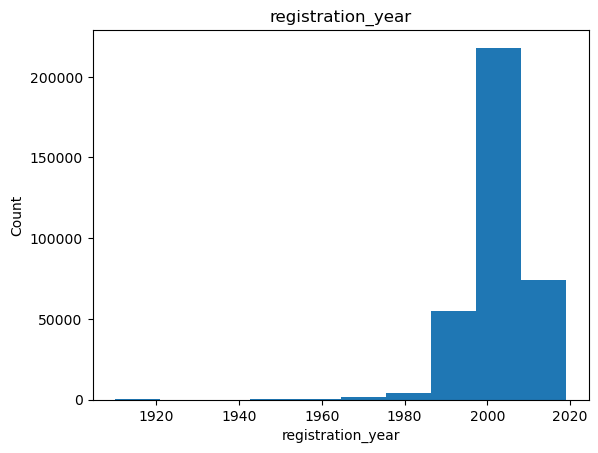

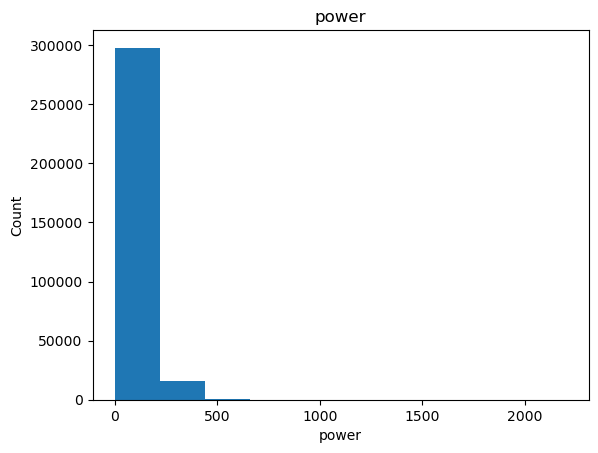

In [371]:
# Display histograms for registration_year and power
cols_missing = ['registration_year', 'power']

for col in cols_missing:
    plt.hist(cars[col])
    plt.title(f'{col}')
    plt.ylabel('Count')
    plt.xlabel(f'{col}')
    plt.show()

Registration year and power are both highly skewed. Missing values will be imputed with the median.

*Impute*

Impute missing power and registration_year with the median.

In [372]:
# Impute missing values in registration_year and power with median 
for col in cols_missing:
    cars[col] = cars[col].fillna(cars[col].median())
    
# Re-print missing values
missing_new_2 = cars.isna().sum().to_frame().rename(columns={0:'count'})
missing_new_2['proportion'] = (missing_new_2 / len(cars)).round(2)

print('Udated missing values:')
display(missing_new_2)

Udated missing values:


,count,proportion
date_crawled,0,0.0
price,0,0.0
vehicle_type,0,0.0
registration_year,0,0.0
gearbox,0,0.0
power,0,0.0
model,0,0.0
mileage,0,0.0
registration_month,0,0.0
fuel_type,0,0.0


All missing values have been filled.

### Prepare data conclusions

* Dates were changed to datetime, missing strings filled with 'unknown', and duplicates cleaned from the dataset.   
* Model was reduced to 125 categories, brand was reduced to 20 categories, and zipcode was truncated to the 1000s place.   
* Incorrect values for registration_year and power were replaced with nan and then filled with the respective medians.   
* The data is prepared and ready for analysis.

[back to top](#home)

## **Exploratory Analysis**<a id='explore'></a>

Density plots, pairplots, and correlations of numeric variables are analyzed to determine the shape and strength of relationships.

### Density plots

Display density plot for each numeric column and examine distribution shape.

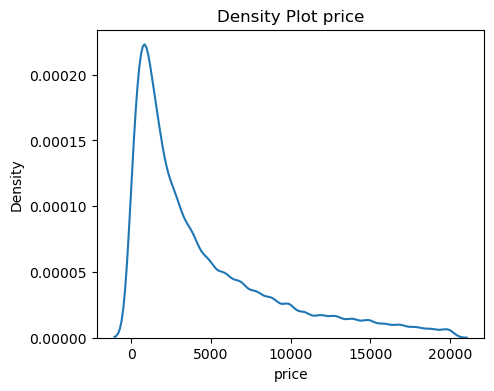

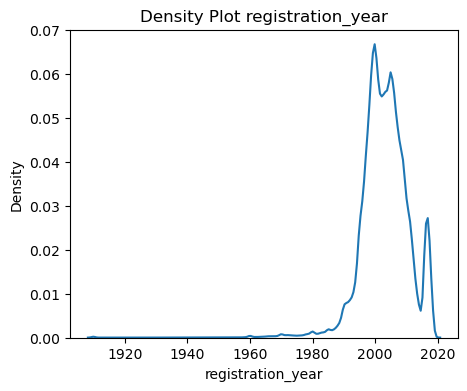

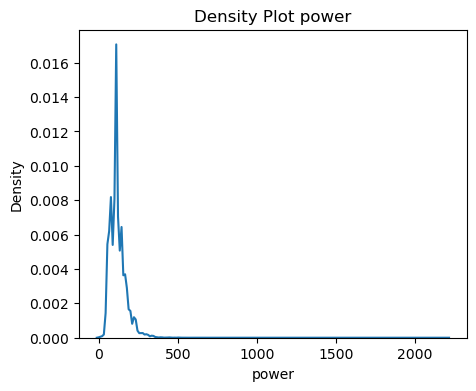

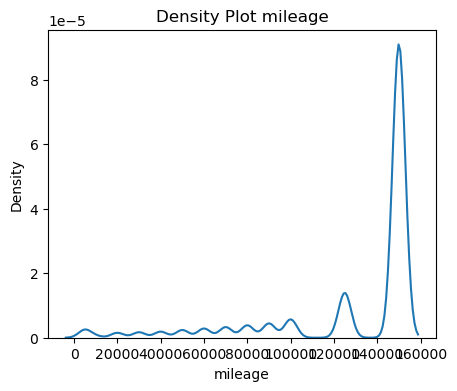

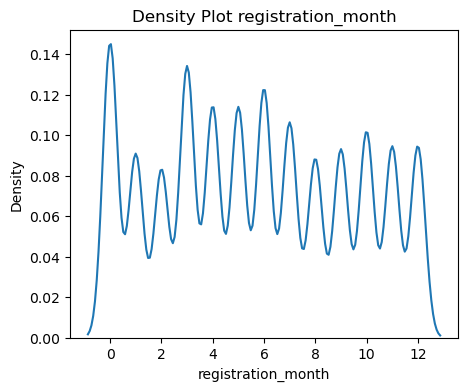

In [410]:
# For each numeric column, display density plot
cols_numeric = ['price', 'registration_year', 'power', 'mileage', 'registration_month']

for col in cols_numeric:
    plt.figure(figsize=(5, 4))
    density = sns.kdeplot(cars[col])
    density.set(title=f'Density Plot {col}')
    
    plt.show()

Price, registration year, power, and mileage are all skewed distributions. Registration month has a fairly uniform distribution. The skew in the independent and dependent variables make this a good candidate for non-parametric mdoels.

### Pairplot and correlations

Display pairplot and correlation matrix of numeric columns to determine shape and strength of relationships.

/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


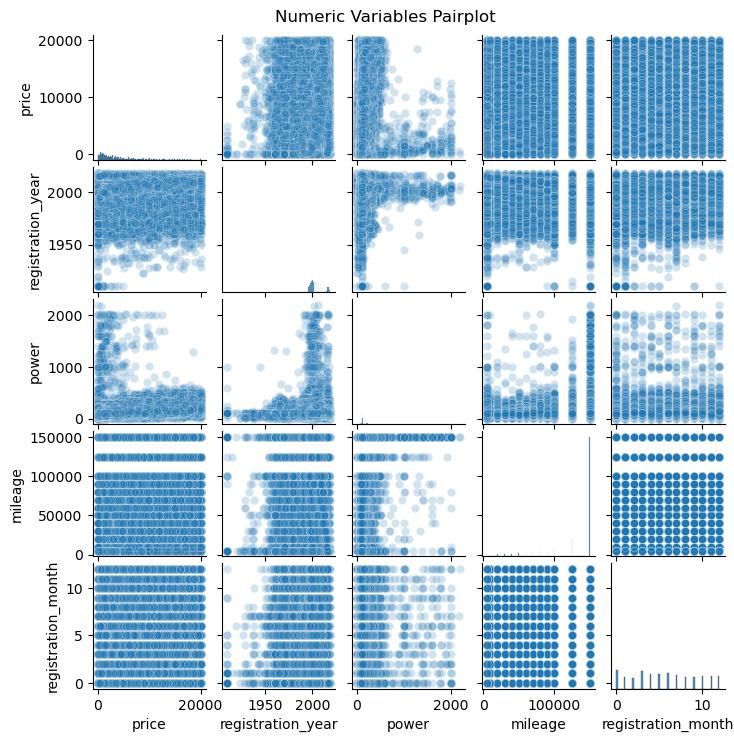

In [374]:
# Display pairplot
pairplot = sns.pairplot(cars[cols_numeric], plot_kws={'alpha':0.2})
pairplot.fig.suptitle('Numeric Variables Pairplot', y=1.02)
pairplot.fig.set_size_inches(7, 7)

plt.show()

There are no clear associations between the dependent variable price and registriation_year, power, mileage, or registration_month. There is also a possible violation of linearity between price and power. There are no apparent linear associations among the independent variables, suggesting that multicolinearity is likely not an issue.

Text(0.5, 1.0, 'Numeric Variables Correlation Heatmap')

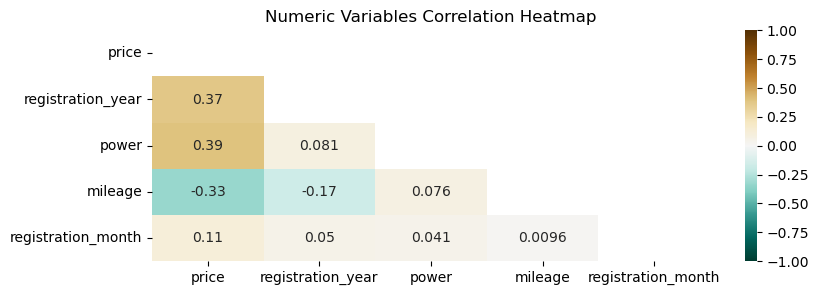

In [411]:
# Correlation matrix
corr_matrix = cars[cols_numeric].corr()
corr_triangle = np.triu(np.ones_like(corr_matrix))

# Correlation heatmap
plt.figure(figsize=(9, 3))
heatmap = sns.heatmap(corr_matrix, mask=corr_triangle, vmin=-1, vmax=1, 
            annot=True, cmap='BrBG_r')
heatmap.set_title('Numeric Variables Correlation Heatmap')

Price has a moderate, positive correlation with registration year (r = 0.37) and power (r = 0.40). Price has a moderate, negative correlation with mileage(r = -0.33). Price is only weakly related to registration month (r = 0.11).

The features registration year, power, and mileage are very weakly correlated with each other. Multicollinearity is not an issue.

### Exploratory analysis conclusions

* Numeric variables all have highly skewed distributions. 
* Features of registration year, power, and mileage are moderately correlation with the target price. The features are not highly correlated with each other, meeting the assumption of non-multicollinearity. 
* There is a possible violation of linearity between price and power.  
* This dataset is a good candidate for non-parametric models. 

[back to top](#home)

## **Regression Model Training**<a id='model'></a>

Numeric features and categorical features with reduced categories are used to build regression models. Dates of activity on the site are likely not predictive of car price and are dropped from the features dataframe.  

**Features**: 
* *vehicle_type* - vehicle body type
* *registration_year* - vehicle registration year
* *gearbox* - gearbox type
* *power* - power (hp)
* *model_top125* 125 most frequent vehicle models
* *mileage* - mileage (km)
* *registration_month* - vehicle registration month
* *fuel_type* - fuel type
* *brand_top20* - 20 most frequent vehicle brands
* *not_repaired* - vehicle repaired or not 
* *postal_code_trunc1000* - postal code truncated to 1000s place

**Target**:  
* *price* - used car price (euros)

**Sections:**  
* [Prepare Training and Test Sets](#prepare)  
* [Define Tranformers and Scorers](#transformer)  
* [Regression Models](#regression)  
* [Decision Tree Regression](#tree)  
* [Random Forest Regression](#forest)  
* [Gradient Boosted Decision Tree Regressions](#gbdt)  
* [Training Results](#results)  
* [Test Results](#test)  
* [Conclusions](#conclude_model)

### Prepare training and test sets<a id='prepare'></a>

In [376]:
# Define features and target
features = cars.drop(['price', 'date_crawled', 'date_created', 'last_seen', 
                          'postal_code', 'number_of_pictures', 'brand', 'model'], axis=1)
target = cars['price']

print('Features:')
display(features.head())
print('Target:')
display(target.head().to_frame())

Features:


,vehicle_type,registration_year,gearbox,power,mileage,registration_month,fuel_type,not_repaired,postal_code_trunc1000,model_top125,brand_top20
0,unknown,1993.0,manual,110.0,150000,0,petrol,unknown,70000,golf,volkswagen
1,coupe,2011.0,manual,190.0,125000,5,gasoline,yes,66000,unknown,audi
2,suv,2004.0,auto,163.0,125000,8,gasoline,unknown,90000,grand,other
3,small,2001.0,manual,75.0,150000,6,petrol,no,91000,golf,volkswagen
4,small,2008.0,manual,69.0,90000,7,gasoline,no,60000,fabia,skoda


Target:


,price
0,480
1,18300
2,9800
3,1500
4,3600


In [377]:
# Split into training at test set
feat_train, feat_test, targ_train, targ_test = train_test_split(features, target, 
                                                                test_size=0.25, random_state=123)

print(f'Feature Train Shape: {feat_train.shape}')
print(f'Feature Test Shape: {feat_test.shape}')
print()
print(f'Target Train Shape: {targ_train.shape}')
print(f'Target Test Shape: {targ_test.shape}')

Feature Train Shape: (265580, 11)
Feature Test Shape: (88527, 11)

Target Train Shape: (265580,)
Target Test Shape: (88527,)


### Define transformers and scorers<a id='transformer'></a>

Set up columns transformer for pipeline and scorers for cross validation.

In [378]:
# Define numeric and categorical columns
cols_numeric = ['registration_year', 'power', 'mileage']
cols_categorical = ['vehicle_type', 'gearbox', 'model_top125', 'registration_month', 
                    'fuel_type', 'brand_top20', 'not_repaired', 'postal_code_trunc1000']

# Define transformer
preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), cols_numeric),
                  ('OHE', OneHotEncoder(handle_unknown='ignore'), cols_categorical)]
)

# Define score list
scorers = {'rmse':'neg_root_mean_squared_error',
            'r2':'r2'}

### Linear Regressions (base model)<a id='regression'></a>

Fit standard and ridge regressions and calculate RMSE as a baseline metric.

##### Standard linear regression

In [379]:
# Cross-validate standard linear regression using pipeline
start = time.time()

pipe = Pipeline(steps=[('transform', preprocessor), ('model', LinearRegression())])
                
linreg_cv = cross_validate(pipe, feat_train, targ_train, scoring=scorers, cv=3)

end = time.time()

# Calculate run time
linreg_time = end - start

print('Linear Regression Train Time:')
print()
print(f'{linreg_time:.2f} seconds')

Linear Regression Train Time:

2.36 seconds


In [380]:
# Print standard linear regression results
linreg_results = cv_results(linreg_cv, 'rmse', 'r2', greater_is_better=False)
linreg_results['time_sec'] = linreg_time

print('Standard Linear Regression Results:')
display(linreg_results.round(2))

Standard Linear Regression Results:


,rmse,r2,time_sec
0,2881.82,0.59,2.36


##### Ridge regression

In [381]:
# Tune ridge regression using pipe and gridsearchcv
start = time.time()

pipe = Pipeline(steps=[('transform', preprocessor), ('model', Ridge())])

grid = {
    'model__alpha':[0, 1e-10, 1e-5, .001, .01, .1, .5, .9, 1.0, 1.1, 1.5, 1.7, 2.0, 5.0]
}

ridge_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers, refit='rmse', cv=3)
ridge_gscv.fit(feat_train, targ_train)

end = time.time()

# Calculate run time
ridge_time = end - start

print('Ridge Regression Train Time:')
print()
print(f'{ridge_time:.2f} seconds')

Ridge Regression Train Time:

27.90 seconds


In [382]:
# Get ridge regression results
ridge_gscv_params, ridge_gscv_results = gscv_results(ridge_gscv, 'rmse', 'r2', 
                                                     greater_is_better=False)

# Append time
ridge_gscv_results['time_sec'] = ridge_time

print('Ridge Regression Best Parameters:')
print(ridge_gscv_params)
print()
print('Ridge Regression Results:')
display(ridge_gscv_results.round(2))

Ridge Regression Best Parameters:
{'model__alpha': 1.1}

Ridge Regression Results:


,rmse,r2,time_sec
0,2881.79,0.59,27.9


#### Linear regression results

* Ridge regression (RMSE = 2881.79) performed only slightly better than standard linear regression (RMSE = 2881.82). This is likely because the number of features, while large, is still smaller than the number of observations. 
* Given ridge regression took 26 seconds longer to fit, standard linear regression would be the prefered out of these two options.  
* Tree models will be fit to improve on these scores.

### Decision tree regressor<a id='tree'></a>

Fit and tune single decision tree to improve on linear regression.

In [383]:
# Tune decision tree
start = time.time()

tree = DecisionTreeRegressor(random_state=123)

pipe = Pipeline([('scale', preprocessor), ('model', tree)])

grid = {
    'model__max_depth':np.arange(1, 21, 1)
}

tree_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers, refit='rmse', cv=3)
tree_gscv.fit(feat_train, targ_train)

end = time.time()

tree_time = end - start

print('Decision Tree Train Time:')
print(f'{tree_time:.2f} seconds')

Decision Tree Train Time:
255.94 seconds


In [384]:
# Get tree model results
tree_gscv_params, tree_gscv_results = gscv_results(tree_gscv, 'rmse', 'r2', greater_is_better=False)
tree_gscv_results['time_sec'] = tree_time

print('Decision Tree Best Parameters:')
print(tree_gscv_params)
print()
print('Decision Tree Results:')
display(tree_gscv_results.round(2))

Decision Tree Best Parameters:
{'model__max_depth': 14}

Decision Tree Results:


,rmse,r2,time_sec
0,2093.69,0.79,255.94


#### Decision tree results

* The decision tree (RMSE = 2093.69) improved upon the the ridge regression (RMSE = 2881.79).   
* The tree took about 4 min longer to tune than ridge regression.

### Random forest regressor<a id='forest'></a>

Random forest fit and tuned to minimize RMSE.

In [385]:
# Tune standard random forest
start = time.time() 

rf_reg = RandomForestRegressor(random_state=123)

pipe = Pipeline([('transform', preprocessor), ('model', rf_reg)])

grid = {
    'model__n_estimators':[10, 20],
    'model__max_depth':[5, 7, 10, 13]
}

rf_reg_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers, refit='rmse', cv=2)
rf_reg_gscv.fit(feat_train, targ_train)

end = time.time()

# Calculate execution time
rf_time = end - start

print('Random Forest Execution Time:')
print(f'{rf_time:.2f} seconds')

Random Forest Execution Time:
340.50 seconds


In [386]:
# Get random forest results
rf_reg_best, rf_gscv_results = gscv_results(rf_reg_gscv, 'rmse', 'r2', greater_is_better=False)
rf_gscv_results['time_sec'] = rf_time

print('Random Forest Best Params:')
print(rf_reg_best)
print()
print('Random Forest Results:')
display(rf_gscv_results.round(2))

Random Forest Best Params:
{'model__max_depth': 13, 'model__n_estimators': 20}

Random Forest Results:


,rmse,r2,time_sec
0,1948.8,0.81,340.5


#### Random forest conclusions

* Random forest (RMSE = 1852.2) improved on the decision tree (RMSE = 2093.69).
* Random forest took 1.5 minutes longer to tune than the decision tree.

### Gradient boosted ensembles<a id='gbdt'></a>

Tune and fit gradient boosted trees with CatBoost and LightGBM to minimize RMSE.

##### CatBoost

Tune and fit boosted trees with CatBoost gradient boosting algorithm.

In [387]:
# Tune CatBoost random forest regressor
start = time.time()

# Categorical features
cols_category = ['vehicle_type', 'gearbox', 'registration_month',
                 'fuel_type', 'not_repaired', 'postal_code_trunc1000',
                 'model_top125', 'brand_top20']

# Initiate model
catboost_reg = CatBoostRegressor(iterations=200,
                                 silent=True,
                                 random_seed=123,
                                 cat_features=cols_category)

# CatBoost directory bug fix
catboost_reg.set_params(train_dir='/tmp/catboost_info')

grid = {
    'learning_rate':[.1, 0.5, 0.7],
    'depth':[5, 7, 10]
}

# Grid search for best hyperparameters
catboost_gscv = GridSearchCV(catboost_reg, param_grid=grid, scoring=scorers, 
                             refit='rmse', cv=3)
catboost_gscv.fit(feat_train, targ_train)

end = time.time()

In [388]:
# Calculate train time
catboost_reg_time = end - start

print('CatBoost Regressor Train Time:')
print(f'{catboost_reg_time:.2f} seconds')

CatBoost Regressor Train Time:
345.97 seconds


In [389]:
catboost_best, catboost_gscv_results = gscv_results(catboost_gscv, 'rmse', 'r2', 
                                                    greater_is_better=False)

catboost_gscv_results['time_sec'] = catboost_reg_time

print('CatBoost Regression Best Params:')
print(catboost_best)
print()
print('CatBoost Regression Results:')
display(catboost_gscv_results.round(2))

CatBoost Regression Best Params:
{'depth': 10, 'learning_rate': 0.1}

CatBoost Regression Results:


,rmse,r2,time_sec
0,1796.18,0.84,345.97


Gradient boosting wtih CatBoost (RMSE = 1796.18) improved predictions compared to the standard random forest (RMSE = 1852.2) and was trained in a quarter of the time.

##### LightGBM

Tune and fit boosted trees with LightGBM algorithm.

In [390]:
# LightGBM Regressor Tuning
start = time.time()

# Change categorical data types to category
cols_category = ['vehicle_type', 'gearbox', 'registration_month',
                 'fuel_type', 'not_repaired', 'postal_code_trunc1000',
                 'model_top125', 'brand_top20']

for col in cols_category:
    feat_train[col]=feat_train[col].astype('category')

# Tune lgbm regressor
lgbm_reg = lgb.LGBMRegressor(n_estimators=300,
                            force_col_wise=True,
                            random_state=123)

grid = {
    'learning_rate':[.1, 0.5, 0.7],
    'num_leaves':[10, 50, 100, 1000],
    'max_depth':[5, 7, 10, 13],
    'verbose':[-1]
}

lgbm_reg_gscv = GridSearchCV(lgbm_reg, param_grid=grid, scoring=scorers, refit='rmse', cv=3)
lgbm_reg_gscv.fit(feat_train, targ_train,
                categorical_feature=cols_category)

end = time.time()

# Calculate train time
lgbm_time = end - start

print('LightGBM Random Forest Train Time:')
print(f'{lgbm_time:.2f} seconds')

LightGBM Random Forest Train Time:
425.35 seconds


In [391]:
lgbm_best, lgbm_results = gscv_results(lgbm_reg_gscv, 'rmse', 'r2', greater_is_better=False)
lgbm_results['time_sec'] = lgbm_time

print('LightGBM Regressor Best Parameters:')
print(lgbm_best)
print()
print('LightGBM Regressor Results:')
display(lgbm_results)

LightGBM Regressor Best Parameters:
{'learning_rate': 0.1, 'max_depth': 13, 'num_leaves': 1000, 'verbose': -1}

LightGBM Regressor Results:


,rmse,r2,time_sec
0,1739.38,0.8518,425.345968


### Regression training results<a id='results'></a>

Compare score and training time across models.

In [392]:
# Create data frame of model results
results_regressors = pd.concat([linreg_results, ridge_gscv_results, tree_gscv_results,
                                rf_gscv_results, catboost_gscv_results, lgbm_results])

results_regressors.index = ['Linear Regression', 'Ridge Regression', 'Decision Tree Regressor',
                            'Random Forest Regressor', 'CatBoost GBDT Regressor', 
                            'LightGBM GBDT Regressor']

print('Regression Training Results:')
display(results_regressors.sort_values(by='rmse').round(2))

Regression Training Results:


,rmse,r2,time_sec
LightGBM GBDT Regressor,1739.38,0.85,425.35
CatBoost GBDT Regressor,1796.18,0.84,345.97
Random Forest Regressor,1948.80,0.81,340.50
Decision Tree Regressor,2093.69,0.79,255.94
Ridge Regression,2881.79,0.59,27.90
Linear Regression,2881.82,0.59,2.36


#### Training conclusions

* LightGBM achieved the lowest RMSE (RMSE = 1739.38) and highest R^2 value (R^2 = 0.85).  
* LightGBM took the longest to tune, but this was due to the large number of hyperparameters entered into the grid. LightGBM was able to tune more hyperparameters options than Random Forest and CatBoost in a similar amount of time.  
* Both standard and ridge regression had very quick computations, but they were over $1000 less accurate in their predictions than  LightGBM GBDT.
* Considering both model score and time, LightGBM GBDT is the best model.

### Test Results<a id='test'></a>

Test LightGBM GBDT regressor on test set.

In [393]:
# Test LightGMB model on test set
start = time.time()

# Convert test objects to category type
for col in cols_category:
    feat_test[col]=feat_test[col].astype('category')

# Predicted values
pred_test = lgbm_reg_gscv.predict(feat_test)

end = time.time()

# Calculate test results
rmse = mean_squared_error(targ_test, pred_test, squared=False)
r2 = r2_score(targ_test, pred_test)
test_time = end - start

# Display test results
test_results = pd.DataFrame(data={'rmse':[rmse],
                                  'r2':[r2],
                                  'time_sec':[test_time]})

print('LightGBM Test Results:')
display(test_results.round(2))


LightGBM Test Results:


,rmse,r2,time_sec
0,1663.85,0.86,1.13


LightGBM GBDT achieved a lower RMSE and higher R^2 on the test set (RMSE = 1663.85, R^2 = 0.86). The model is likely not overfit. It was able to make predictions in less than one second.

<Figure size 500x400 with 0 Axes>

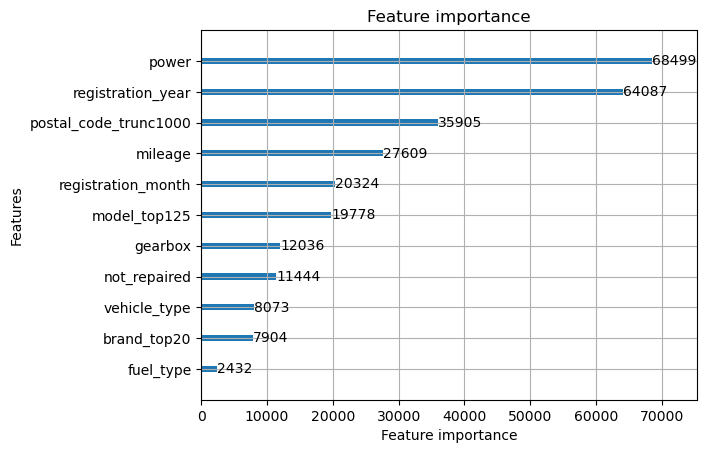

In [409]:
# Plot feature importance
plt.figure(figsize=[5, 4])

lgb.plot_importance(lgbm_reg_gscv.best_estimator_)

plt.show()

* Power and registration_year are the most important features for predicting price. These are followed by postal code, mileage, registration month, and model type. 
* The least important features are vehicle type, brand, and fuel type.

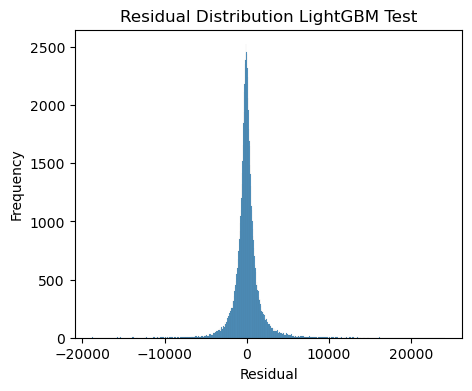

In [394]:
# Residual histogram
residuals = targ_test - pred_test

plt.figure(figsize=[5, 4])

sns.histplot(residuals)

plt.title('Residual Distribution LightGBM Test')
plt.ylabel('Frequency')
plt.xlabel('Residual')

plt.show()

Model residuals are normal and centered at 0.

Text(0.5, 0, 'Car Price')

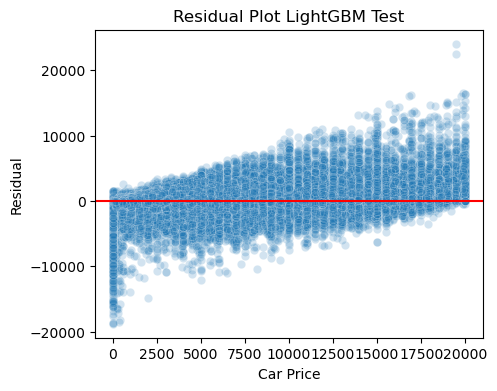

In [398]:
# Residual Plot
plt.figure(figsize=[5, 4])

sns.scatterplot(x=targ_test, y=residual, alpha=0.2)
plt.axhline(0, color='red')

plt.title('Residual Plot LightGBM Test')
plt.ylabel('Residual')
plt.xlabel('Car Price')

The residual plot shows a slight pattern in residuals, sloping up to the right. The model tends to overpredict price for less expensive cars and under predict price for more expensive cars. The issue could be addressed in the future through further data cleaning, further tuned models, or data transformation.

#### Test conclusions

* LightGBM GBDT achieved a lower RMSE on the test set (RMSE = 1663.85) than on the training set (RMSE = 1739.38). This means the model was able to make better predictions on the test data than on the training data and shows evidence that the model is likely not overfit.
* An RMSE of 1663.85 means that the model's predicted values are, on average, $1,663.85 different than the actual value of the car. 
* Viewing the model's residual plots shows the residuals are normally distributed around 0 but have a slight pattern in the residual plot. Further analysis may consider furhther data cleaning, tuning additional hyperparameters, and data transformations to address the issue.

### Model Training Conclusions<a id='conclude_model'></a>

* Five types of regression models were fit and cross-validated on the training data, including standard regression, ridge regression, decision tree, random forest, and gradient boosted trees. 
* LightGBM GBDT best minimized RMSE on the training data and tuned in 425 seconds (RMSE = 1739.38).
* LightGBM GBDT was then tested on the test data and achieved a lower RMSE on the test data (RMSE = 1663.83).
* The model is likely not overfit, though there are some small concerns with residual pattern. This issue could be resolved in the future with further data cleaning, model tuning, or data transformation.

[back to top](#home)

## **Conclusions and Business Application**<a id='conclusion'></a>

**Conclusions:** Of the regression models tested, LightGBM GBDT achieved the best model fit (RMSE test = 1663.83). It was also able to tune more hyperparameters than CatBoost in a similar amount of time. The most important features were predicting price were power, registration year, postal code, and mileage.

**Business Application:** Rusty Bargain can be confident that predictions from this model will offer customers the predicted value of their car within $1,663.83 on average. Customers will only have to wait about 1 second for the model to predict the value of their car. This model is speedy and accurate for Rusty Bargain to impliment on their app.

**Future Research:** As a class project, this analysis was limited to time constraints. With additional time, more hyperparameters and trees/iterations could be performed to improve model accuracy. Additionally, further data cleaning may improve the accuracy of the results.

[back to top](#home)